# LOGISTIC REGRESSION MODEL
CONTRIBUTORS: Will, John, Ben, and James Ogle

PURPOSE: The jupyter notebook is designed to take in Ednet-KT1 data set and merge all of the files into one csv. The data is used to build a logistic regression model that predicts if the question was answered correctly based off the average question accuracy, question_id, bundle_id, and elapsed time to asnwer question. The model will be used as a baseline to determine if a relationship can be found between the data taken from students and if the student answered correctly. 

### Dataset Content Description
- **timestamp** is the moment the question was given, represented as Unix timestamp in milliseconds.
- **solving_id** represents each learning session of students corresponds to each bunle. It is a form of single
integer, starting from 1 .
- **question_id** is the ID of the question that given to student, which is a form of q{integer}.
- **user_answer** is the answer that the student submitted, recorded as a character between a and d inclusively.
- **elapsed_time** is the time that the students spends on each question in milliseconds.


### Our Dataset
We plan to reduce the data to have only columns for student_id, question_id, bundle_id, tags, elapsed_time, and correct
- **student_id** is the ID of the student. We will not use this for training, but it's necessary for sorting so that we don't leak data
- **bundle_id** is the bundle that a question is in. Bundles are sets of questions that reference the same passage/image/video/etc
- **tags** are the skills associated with a certain question. Most question have multiple tags.
- **Correct** is whether or not the student got the answer correct in that interaction

In [36]:
import os
import polars as pl # Using polars instead of pandas for speed. >9 million lines in 784k csv files.
from tqdm import tqdm
import pandas as pd
import pyarrow as pa # Needed for conversion from polars to pandas
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#### Data Merging Preparation
Our original dataset is comprised of one csv file per each of the 784k students, which results in massive overhead when reading in data. To prevent this, we're taking all of the relevant data and merging it into one unified dataset that can be easily read, navigated, and edited.

In [ ]:
kt1_dir = "Data/KT1"
questions_fname = "Data/contents/questions.csv"

# Load important columns of questions file (finding correct_answer and tags)
# This only needs to be done once but we'll reference it multiple times per student interaction
questions = (
    pl.read_csv(questions_fname)
    .with_columns([
        pl.col("question_id").str.replace("q", "").cast(pl.Int32),
        pl.col("bundle_id").str.replace("b", "").cast(pl.Int32),
        pl.col("tags").cast(pl.Utf8)
    ])
    .select(["question_id", "correct_answer", "bundle_id", "tags"])
)


student_files = [os.path.join(kt1_dir, f) for f in os.listdir(kt1_dir) if f.endswith(".csv")]

dfs = []

### Data Fetching and Merging
Here, we take all of the information that we need from each KT1 file and combine it into a single .csv

In [ ]:
# For each interaction, we take the student_id, question_id, bundle_id, tags, elapsed_time, and whether they answered correctly
for file in tqdm(student_files, desc="Progress"):
    # Take student_id from filename, remove 'u' prefix to make it int
    student_id = int(os.path.basename(file).replace("u", "").replace(".csv", ""))

    df = (
        pl.read_csv(file)
        .with_columns([
            pl.lit(student_id).alias("student_id"),
            pl.col("question_id").str.replace("q", "").cast(pl.Int32), # Remove 'q' prefix to make question_id int
        ])
        .join(questions, on="question_id", how="left")
        .with_columns([
            # Adds 'correct' column, which details if student got the question correct
            (pl.col("user_answer").str.strip_chars().str.to_lowercase() == pl.col("correct_answer").str.strip_chars().str.to_lowercase())
            .cast(pl.Int8)
            .alias("correct")
        ])
        .select(["student_id", "question_id", "bundle_id", "tags", "elapsed_time", "correct"])
    )

    # Tags are currently in a list, we need to flatten them so they work in csv
    df = df.with_columns(
        pl.col("tags")
        .cast(pl.Utf8)
        .str.replace_all(r"\[|\]|\s", "")
        .str.replace_all(",", ";")
        .alias("tags")
    )

    dfs.append(df)

# Sort by student_id, then question_id
final_df = pl.concat(dfs, how="vertical").sort(["student_id", "question_id"])

fname = "combined_dataset.csv"
final_df.write_csv(fname)
print(f"Saved {fname}")

### Data Engineering

Sample of what data set will be used for training the logistic regression model

In [37]:
sample_data = pd.read_csv("sample_combined_dataset.csv")
print(sample_data.head())

   student_id  question_id  bundle_id          tags  elapsed_time  correct
0           1            7          7  11;7;179;183         26000      1.0
1           1            7          7  11;7;179;183         37000      0.0
2           1           10         10      17;7;182         28000      0.0
3           1           10         10      17;7;182         26000      0.0
4           1           11         11      15;2;181         42000      0.0


### Model 1 Baseline Accuracy 
By taking the student accuracy, we are able to have a baseline off how accurately the student's guess the correct asnwer. Our model should aim to be above this score to be consisdered useful

In [38]:
data = pl.read_csv(rf".\Data\combined_dataset.csv")
df = data.to_pandas() # Convert from polars to pandas

correct_count = df['correct'].value_counts()
student_acc = correct_count.get(1) / (correct_count.get(0) + correct_count.get(1))
print(f"Overall student accuracy: {student_acc:.4%}")

Overall student accuracy: 65.3418%


Our baseline accuracy to compare against is 65.3418%, which is what we would get if the model guessed that the student will be 'correct' every time.

## Preprocessing: 
- Remove student_id
- Remove question_id and bundle_id and replace with question_acc
- Remove tags
- Standardize elapsed_time

In [39]:
acc_per_question = df.groupby('question_id')['correct'].mean()
df['question_acc'] = df['question_id'].map(acc_per_question)

#df = df.drop(columns=['student_id', 'question_id', 'bundle_id', 'tags'])
df = df.drop(columns=['student_id', 'tags'])
df.insert(1, 'question_acc', df.pop('question_acc'))
df.head()

,question_id,question_acc,bundle_id,elapsed_time,correct
0,7,0.470443,7,26000,1.0
1,7,0.470443,7,37000,0.0
2,10,0.299722,10,28000,0.0
3,10,0.299722,10,26000,0.0
4,11,0.682068,11,42000,0.0


Finish preparation of data set by filling in NA values with 0. We are assuming if the student did not answer in time, then the answer would be counted wrong. 

In [40]:
y = df['correct'].fillna(0)
print(y)
X = df.drop(columns=['correct'])

rng1 = np.random.RandomState(seed=865)

# Split data into training/validation 85/15
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)
X_train = X_train.fillna(0)

0           1.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
95293921    0.0
95293922    0.0
95293923    0.0
95293924    1.0
95293925    1.0
Name: correct, Length: 95293926, dtype: float64


Plotting function used to display the distribution of the data set

In [41]:
def get_info (column):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
  ax1.boxplot(column.dropna())
  ax1.set_title(f"Distribution of {column.name}")
  ax1.set_ylabel("Value")

  ax2.hist(column.dropna(), bins=20)
  ax2.set_title(f"Histogram of {column.name}")
  ax2.set_ylabel("Frequency")
  ax2.set_xlabel("Value")

  ax3.scatter(np.arange(len(column.dropna())), column.dropna())
  ax3.set_title(f"{column.name} Values")
  ax3.set_ylabel("Value")
  ax3.set_xlabel("")

  plt.tight_layout(pad=3.0)
  plt.savefig(f"{column.name}_distribution.png")
  plt.show()
  return column.std()

The question accuracy data based off random sampling of 50,000 shows that most questions had around 55% to 85% accuracy.

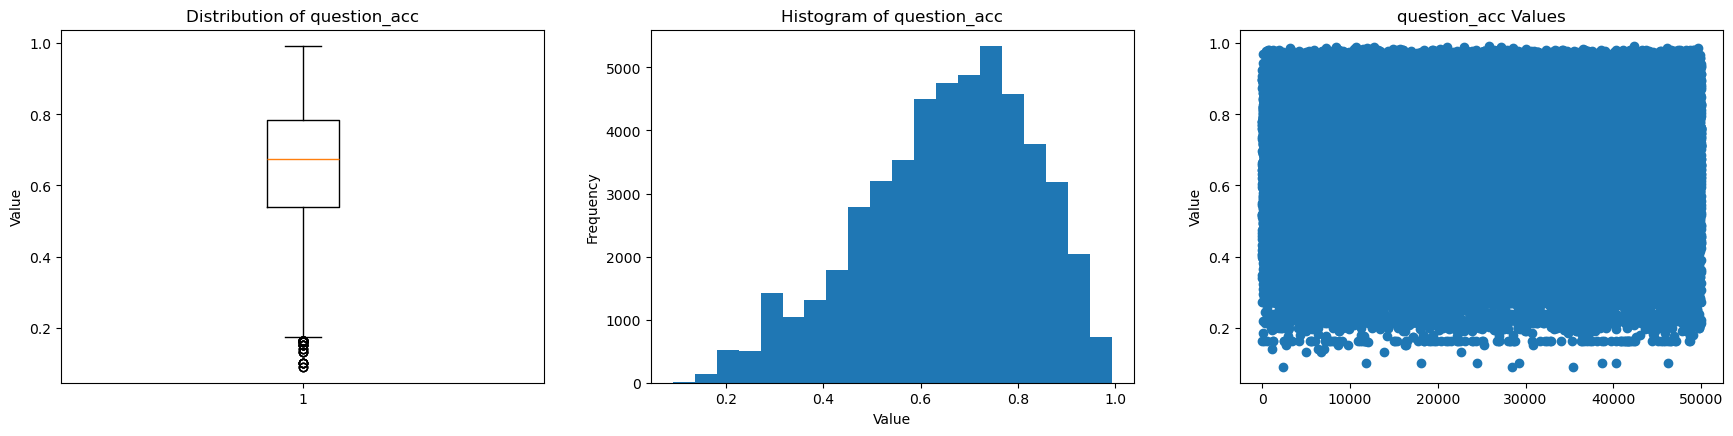

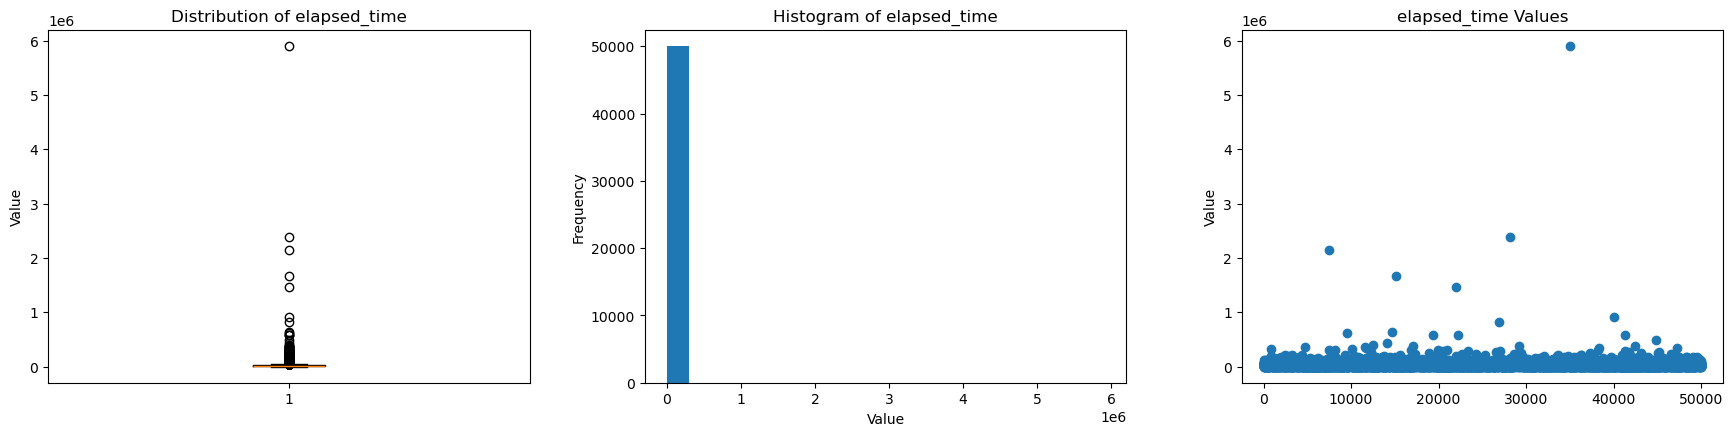

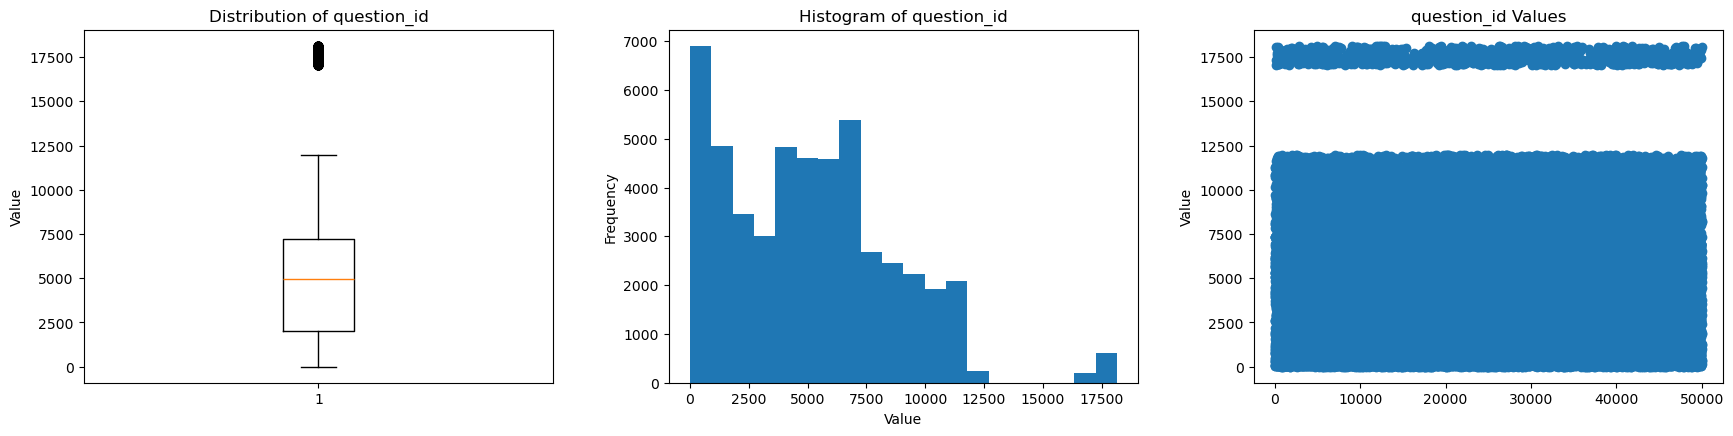

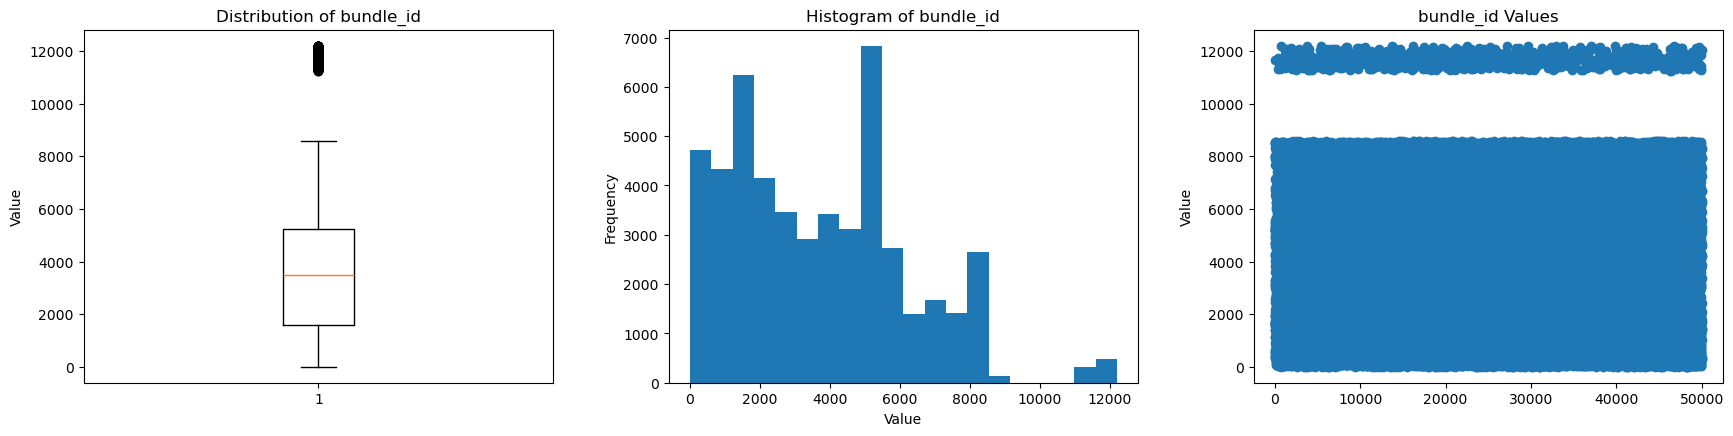

Standard Deviation of Question Accuracy: 0.1752
Standard Deviation of Elapsed Time: 38052.6180
Standard Deviation of Question_id: 3593.2751
Standard Deviation of Bundle_id: 2531.9422



In [42]:
quest_acc_sample = X_train['question_acc'].sample(n=50000)
elp_time_sample = X_train['elapsed_time'].sample(n=50000)
quest_id_sample = X_train['question_id'].sample(n=50000)
bundle_id_sample = X_train['bundle_id'].sample(n=50000)

std_dev_quest_acc = get_info(quest_acc_sample)
std_dev_elp_time = get_info(elp_time_sample)
std_dev_qest_id = get_info(quest_id_sample)
std_dev_bund_id = get_info(bundle_id_sample)
print(f"Standard Deviation of Question Accuracy: {std_dev_quest_acc:.4f}\n"
      f"Standard Deviation of Elapsed Time: {std_dev_elp_time:.4f}\n"
      f"Standard Deviation of Question_id: {std_dev_qest_id:.4f}\n"
      f"Standard Deviation of Bundle_id: {std_dev_bund_id:.4f}\n")

Data is normalized based off results of distribution displayed above
- question_id, elapsed_time, and bundle_id will all be normalized based off standard scalar due to their skewed distributions based of histogram chart
- elapsed_time will most likely require some more data trimming due to the large outliers displayed above

In [43]:
norm_scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), ['elapsed_time', 'question_id', 'bundle_id']),
        ('minmax', MinMaxScaler(), ['question_acc'])
    ]
)

pipe = make_pipeline(norm_scaler, LogisticRegression(max_iter=1000, random_state=865))
pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard', ...), ('minmax', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
# Predict on training set
y_hat = pipe.predict(X_train)
print(f"Model training accuracy is {accuracy_score(y_train, y_hat)*100:0.2f}%")
# Predict on validation set
y_hat = pipe.predict(X_val)
print(f"Model validation accuracy is {accuracy_score(y_val, y_hat)*100:0.2f}%")

Model training accuracy is 70.04%
Model validation accuracy is 70.04%
